### Importing Libraries

In [1]:
import pandas as pd
import re
import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.stem import PorterStemmer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import ENGLISH_STOP_WORDS
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import preprocessing

### Pre Processing Step

In [2]:
# Load the CSV
file_path = "NewsData.io_TSLA.csv"  # Adjust path if needed
df = pd.read_csv(file_path)

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13307 entries, 0 to 13306
Data columns (total 24 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   article_id       13307 non-null  object 
 1   title            13307 non-null  object 
 2   link             13307 non-null  object 
 3   keywords         9337 non-null   object 
 4   creator          11907 non-null  object 
 5   video_url        0 non-null      float64
 6   description      12944 non-null  object 
 7   content          11644 non-null  object 
 8   pubDate          13307 non-null  object 
 9   pubDateTZ        13307 non-null  object 
 10  image_url        11625 non-null  object 
 11  source_id        13307 non-null  object 
 12  source_priority  13307 non-null  object 
 13  source_name      13267 non-null  object 
 14  source_url       13267 non-null  object 
 15  source_icon      13222 non-null  object 
 16  language         13307 non-null  object 
 17  country     

In [5]:
df["ai_tag"].value_counts()

ai_tag
"financial markets"                                   5183
"automotive"                                          3052
"corporate news"                                      1152
"awards and recognitions"                              407
"corporate news,financial markets"                     358
                                                      ... 
"politics,religion,religious events and festivals"       1
"renewable energy"                                       1
"television,social media and internet"                   1
"automotive,economy"                                     1
"eco-friendly,renewable energy,energy"                   1
Name: count, Length: 177, dtype: int64

In [6]:
# Checking distinct languages and counting values
df['language'].value_counts()

language
"english"       10523
"spanish"        2748
"german"           14
"french"           13
"romanian"          7
"portuguese"        1
"italian"           1
Name: count, dtype: int64

In [7]:
# Drop rows with missing sentiment or content
df_en = df.dropna(subset=["sentiment", "content"])

# Storing only english content in new df
df_en = df_en[df_en['language'] == '"english"']

# Quick look
df_en[["pubDate", "title", "sentiment"]].head()

,pubDate,title,sentiment
0,"""2025-01-15 22:16:52""","""My Prediction for 2025 – and a Profit-Generat...","""positive"""
1,"""2025-01-15 22:00:00""","""Boeing needs 'tough love,' says Trump's trans...","""positive"""
6,"""2025-01-15 21:13:08""","""NASDAQ snaps five-day losing streak with its ...","""positive"""
7,"""2025-01-15 20:55:20""","""What's Going On With Tesla Shares Wednesday?""","""neutral"""
8,"""2025-01-15 20:42:47""","""Electric Vehicle Sales Leaders — Best Selling...","""neutral"""


In [8]:
from nltk.stem import WordNetLemmatizer
import nltk
nltk.download("wordnet")

lemmatizer = WordNetLemmatizer()

def basic_preprocess(text):
    text = str(text).lower()
    text = re.sub(r"[^a-zA-Z0-9\s]", " ", text)
    text = re.sub(r"\s+", " ", text).strip()
    tokens = text.split()
    tokens = [word for word in tokens if word not in ENGLISH_STOP_WORDS and word.isalpha()]
    tokens = [lemmatizer.lemmatize(word) for word in tokens]
    tokens = [word for word in tokens if len(word) > 1]
    return " ".join(tokens)


[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\Samir\AppData\Roaming\nltk_data...


In [9]:
# Show original content
df_en["content"].head(5)

0    "Hello, Reader. Mark Twain once remarked, “The...
1    "President-elect Donald Trump’s nominee to suc...
6    "The major stock indices cheered on the combin...
7    "Tesla, Inc . TSLA stock is trading higher on ...
8    "A closer look at the best-selling PEV automot...
Name: content, dtype: object

In [10]:
# Apply to content
df_en["clean_content"] = df_en["content"].apply(basic_preprocess)
df_en["clean_title"] = df_en["title"].apply(basic_preprocess)
df_en["clean_description"] = df_en["description"].apply(basic_preprocess)

### Plot Most Common Function

In [11]:
def plot_most_common_features(text_col, target_col, n_features=50):
    from matplotlib import interactive

    df = pd.DataFrame({"text": text_col, "CLASS": target_col})
    grouped = df.groupby(["CLASS"]).apply(lambda x: x["text"].sum())
    grouped_df = pd.DataFrame({"CLASS": grouped.index, "text": grouped.values})

    from nltk.tokenize import WhitespaceTokenizer
    tokenizer = WhitespaceTokenizer()

    for ii, text in enumerate(grouped_df.text):
        pd.DataFrame(tokenizer.tokenize(text)).apply(pd.value_counts).head(n_features).plot(kind="bar", cmap=plt.cm.seismic, figsize=(20,5))
        plt.title(grouped_df.CLASS[ii], fontsize=20)
        plt.xticks(fontsize=15)
        plt.legend([])
        interactive(True)
        plt.show()

### Plot most common - Clean Content

C:\Users\Samir\AppData\Local\Temp\ipykernel_6732\3495920787.py:5: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  grouped = df.groupby(["CLASS"]).apply(lambda x: x["text"].sum())
C:\Users\Samir\AppData\Local\Temp\ipykernel_6732\3495920787.py:12: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  pd.DataFrame(tokenizer.tokenize(text)).apply(pd.value_counts).head(n_features).plot(kind="bar", cmap=plt.cm.seismic, figsize=(20,5))


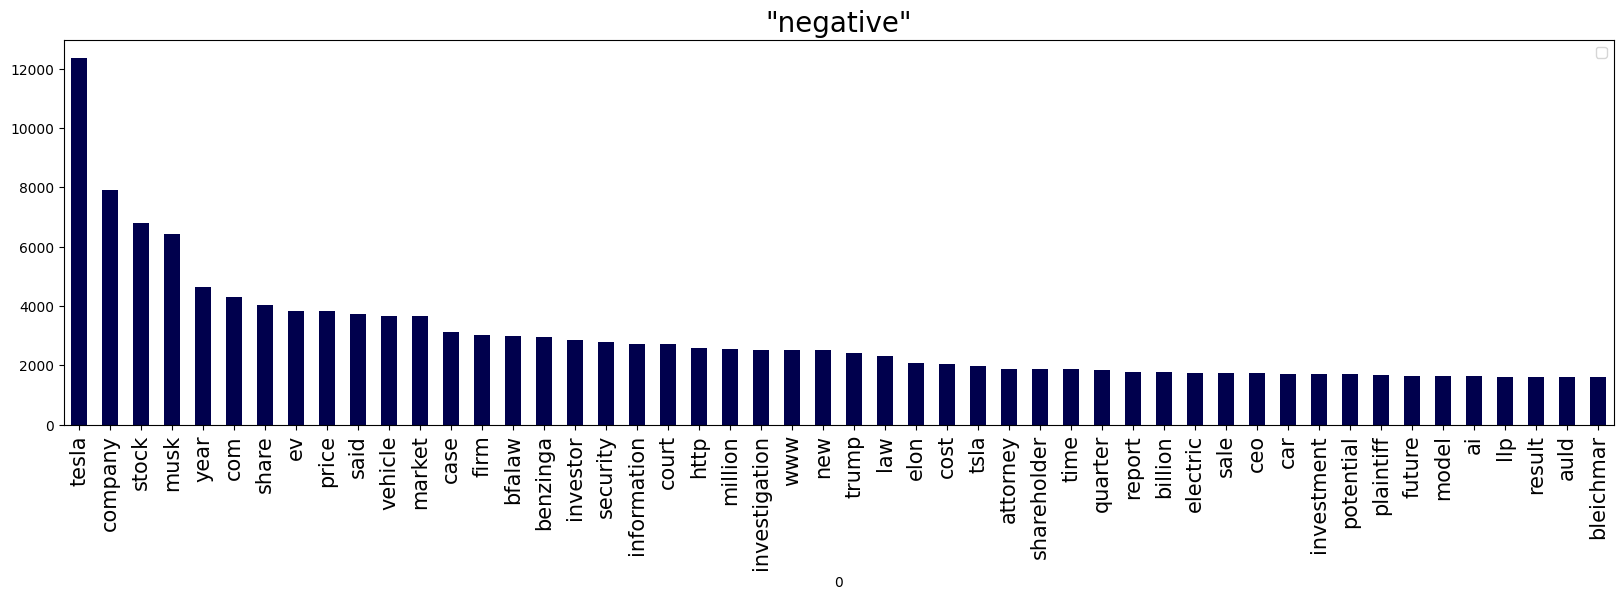

C:\Users\Samir\AppData\Local\Temp\ipykernel_6732\3495920787.py:12: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  pd.DataFrame(tokenizer.tokenize(text)).apply(pd.value_counts).head(n_features).plot(kind="bar", cmap=plt.cm.seismic, figsize=(20,5))


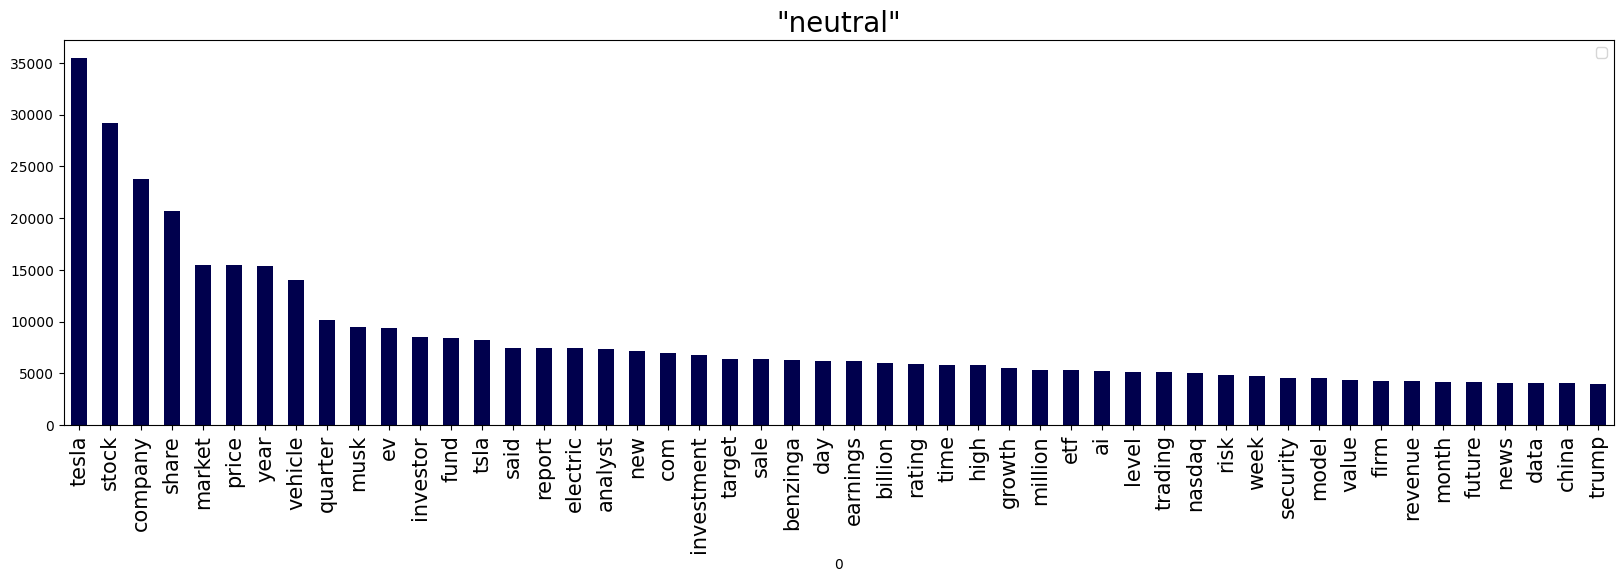

C:\Users\Samir\AppData\Local\Temp\ipykernel_6732\3495920787.py:12: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  pd.DataFrame(tokenizer.tokenize(text)).apply(pd.value_counts).head(n_features).plot(kind="bar", cmap=plt.cm.seismic, figsize=(20,5))


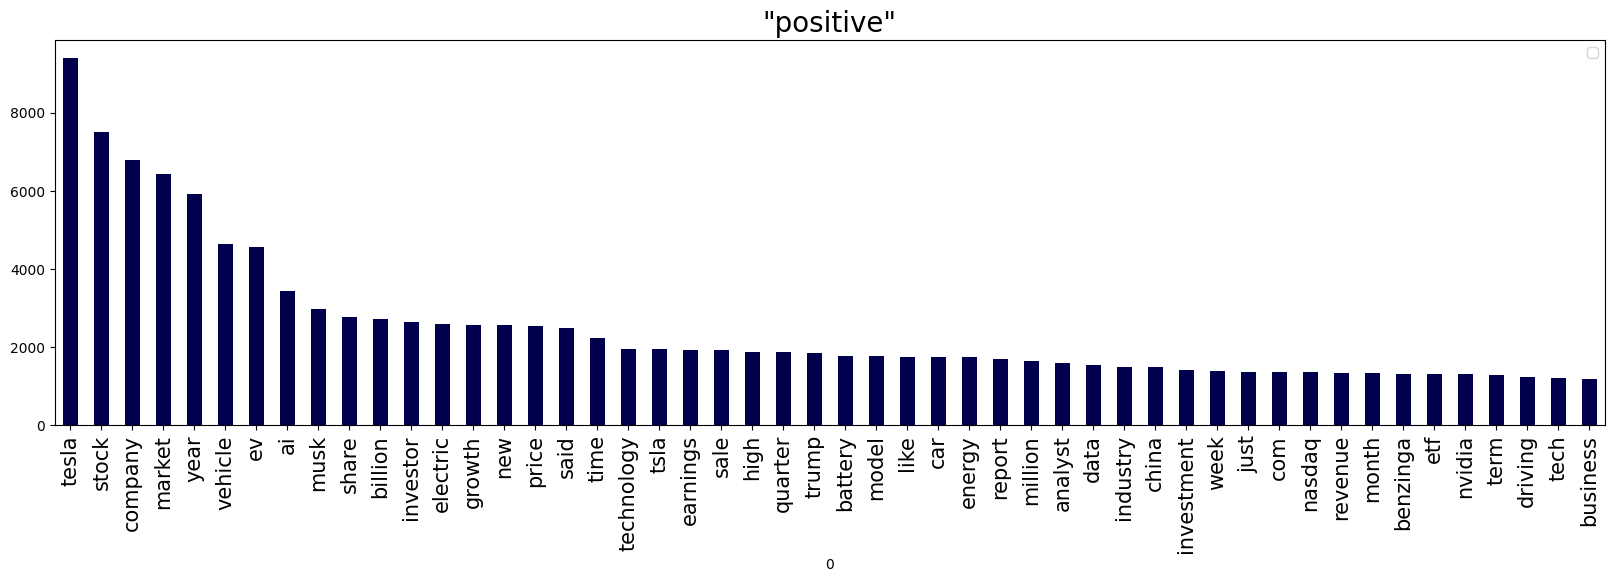

In [12]:
plot_most_common_features(df_en.clean_content, df_en.sentiment)

###  Plot most common - Clean Title

C:\Users\Samir\AppData\Local\Temp\ipykernel_6732\3495920787.py:5: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  grouped = df.groupby(["CLASS"]).apply(lambda x: x["text"].sum())
C:\Users\Samir\AppData\Local\Temp\ipykernel_6732\3495920787.py:12: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  pd.DataFrame(tokenizer.tokenize(text)).apply(pd.value_counts).head(n_features).plot(kind="bar", cmap=plt.cm.seismic, figsize=(20,5))


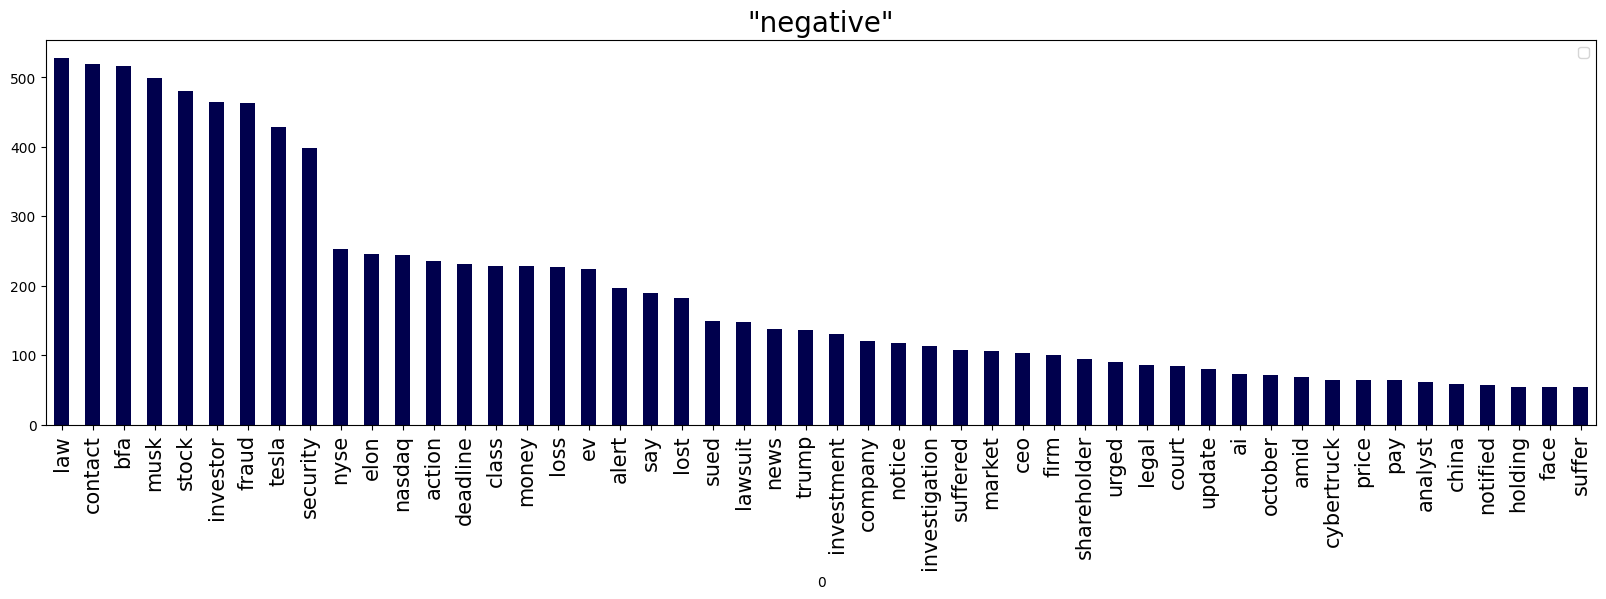

C:\Users\Samir\AppData\Local\Temp\ipykernel_6732\3495920787.py:12: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  pd.DataFrame(tokenizer.tokenize(text)).apply(pd.value_counts).head(n_features).plot(kind="bar", cmap=plt.cm.seismic, figsize=(20,5))


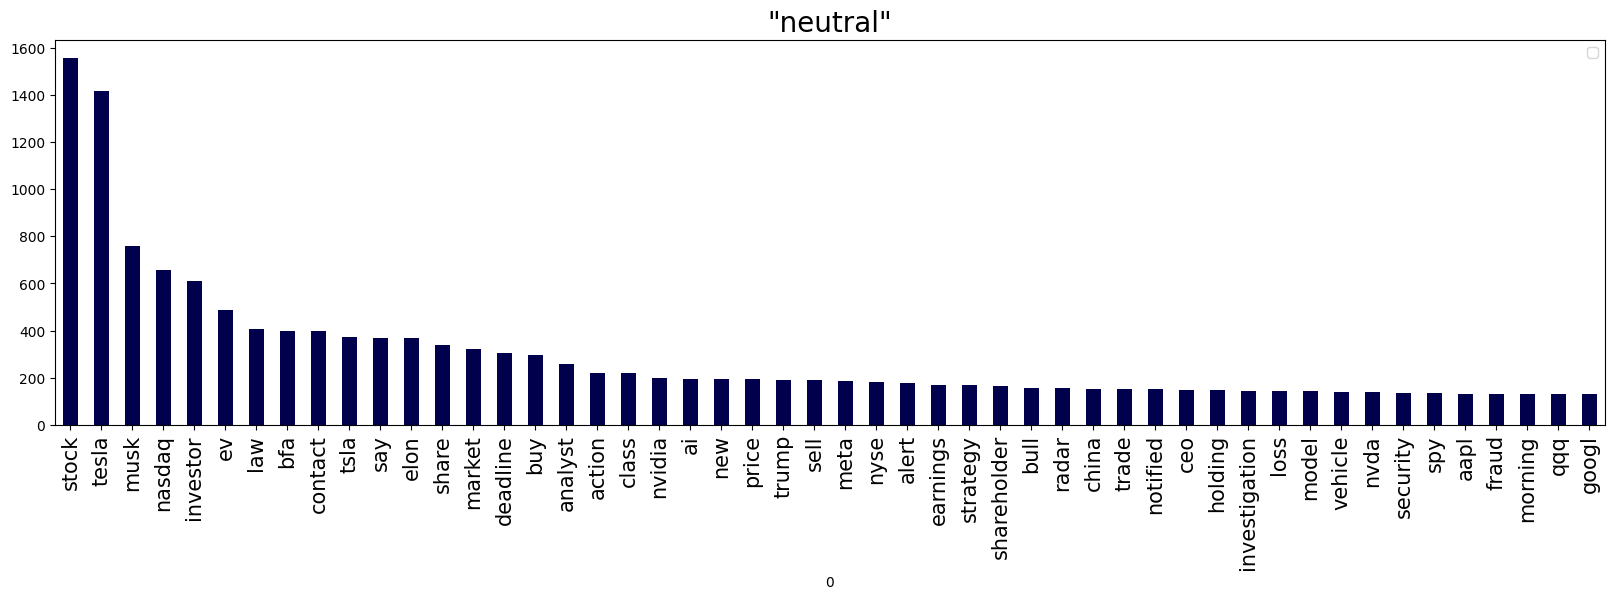

C:\Users\Samir\AppData\Local\Temp\ipykernel_6732\3495920787.py:12: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  pd.DataFrame(tokenizer.tokenize(text)).apply(pd.value_counts).head(n_features).plot(kind="bar", cmap=plt.cm.seismic, figsize=(20,5))


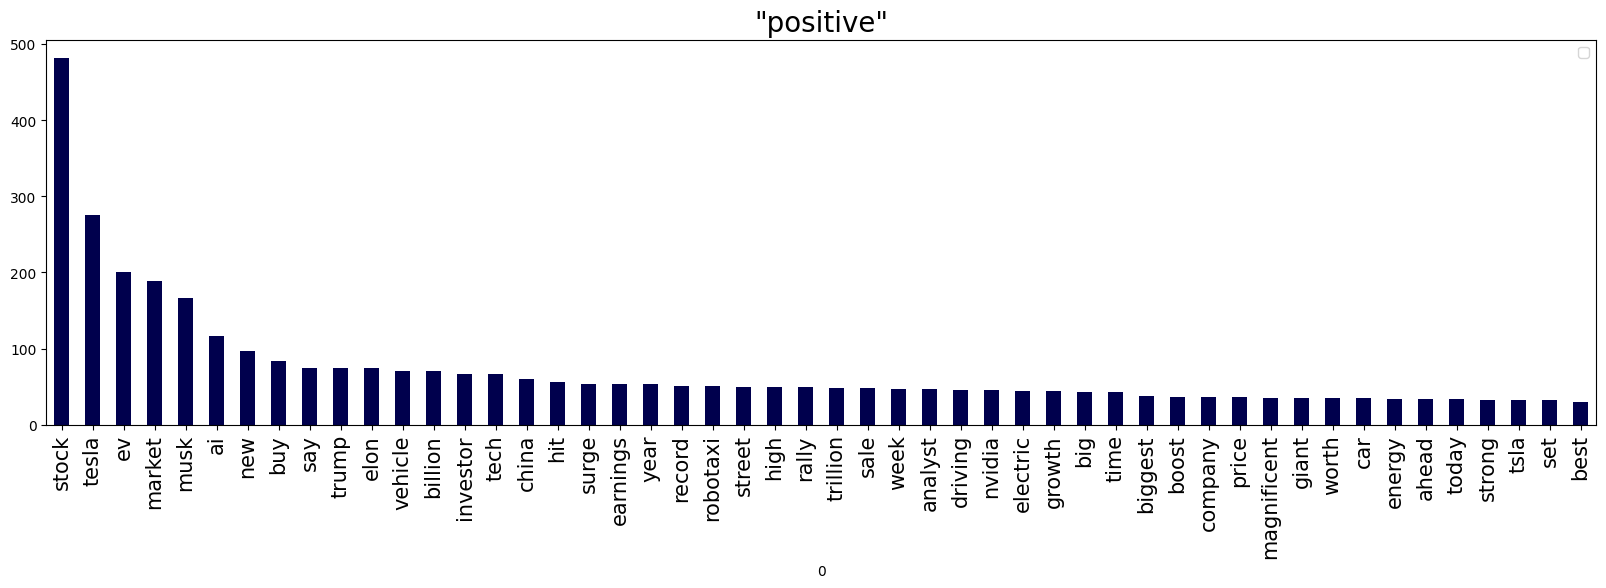

In [13]:
plot_most_common_features(df_en.clean_title, df_en.sentiment)

###  Plot most common - Clean Description

C:\Users\Samir\AppData\Local\Temp\ipykernel_6732\3495920787.py:5: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  grouped = df.groupby(["CLASS"]).apply(lambda x: x["text"].sum())
C:\Users\Samir\AppData\Local\Temp\ipykernel_6732\3495920787.py:12: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  pd.DataFrame(tokenizer.tokenize(text)).apply(pd.value_counts).head(n_features).plot(kind="bar", cmap=plt.cm.seismic, figsize=(20,5))


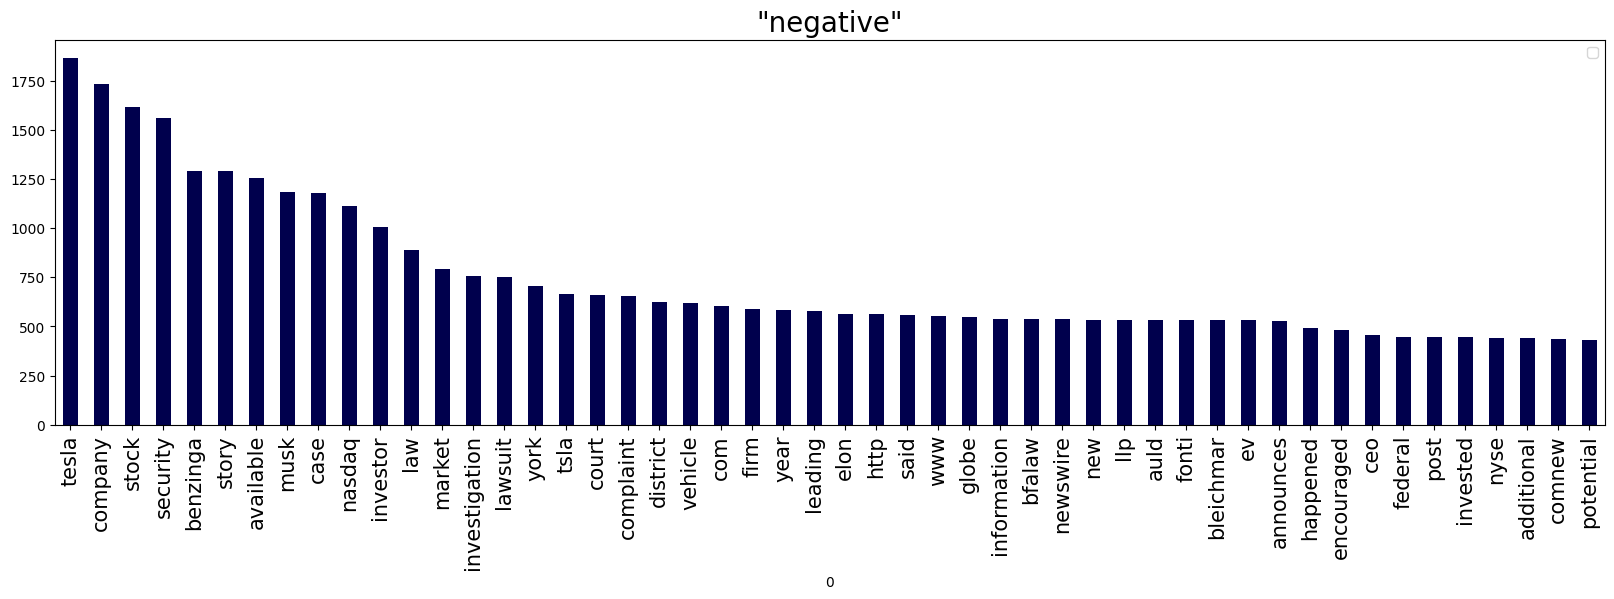

C:\Users\Samir\AppData\Local\Temp\ipykernel_6732\3495920787.py:12: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  pd.DataFrame(tokenizer.tokenize(text)).apply(pd.value_counts).head(n_features).plot(kind="bar", cmap=plt.cm.seismic, figsize=(20,5))


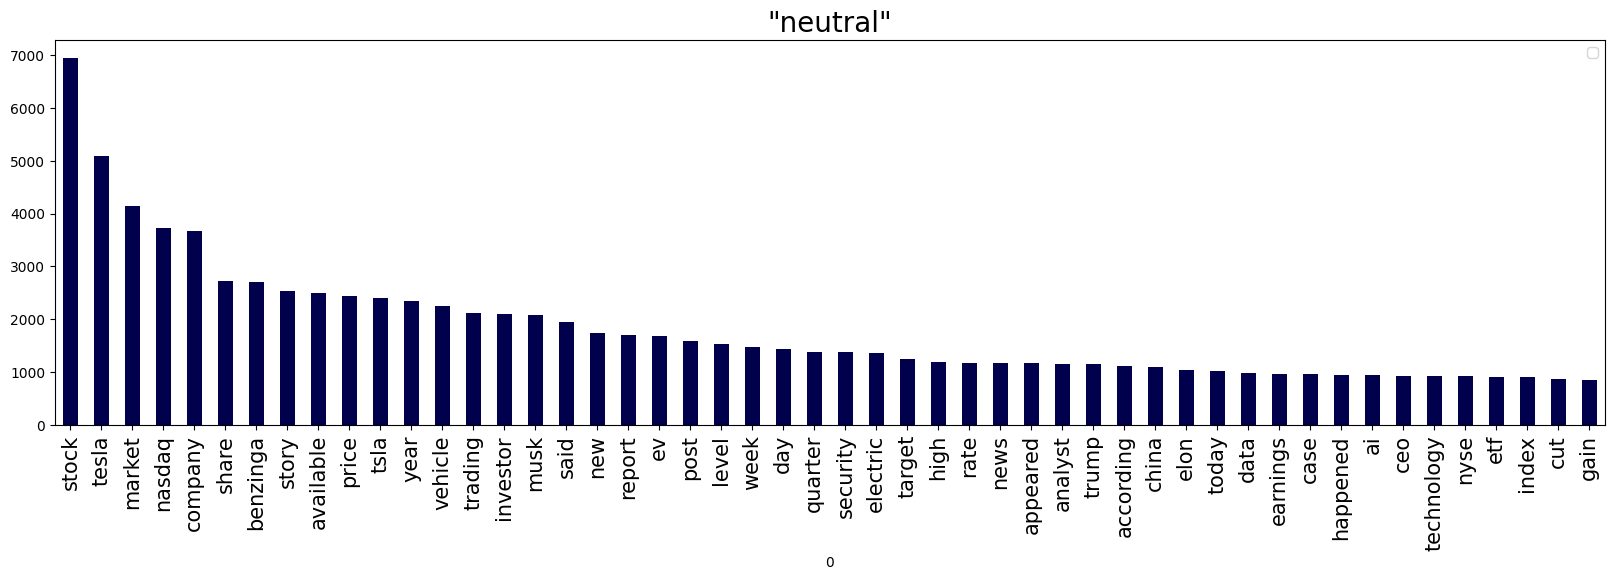

C:\Users\Samir\AppData\Local\Temp\ipykernel_6732\3495920787.py:12: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  pd.DataFrame(tokenizer.tokenize(text)).apply(pd.value_counts).head(n_features).plot(kind="bar", cmap=plt.cm.seismic, figsize=(20,5))


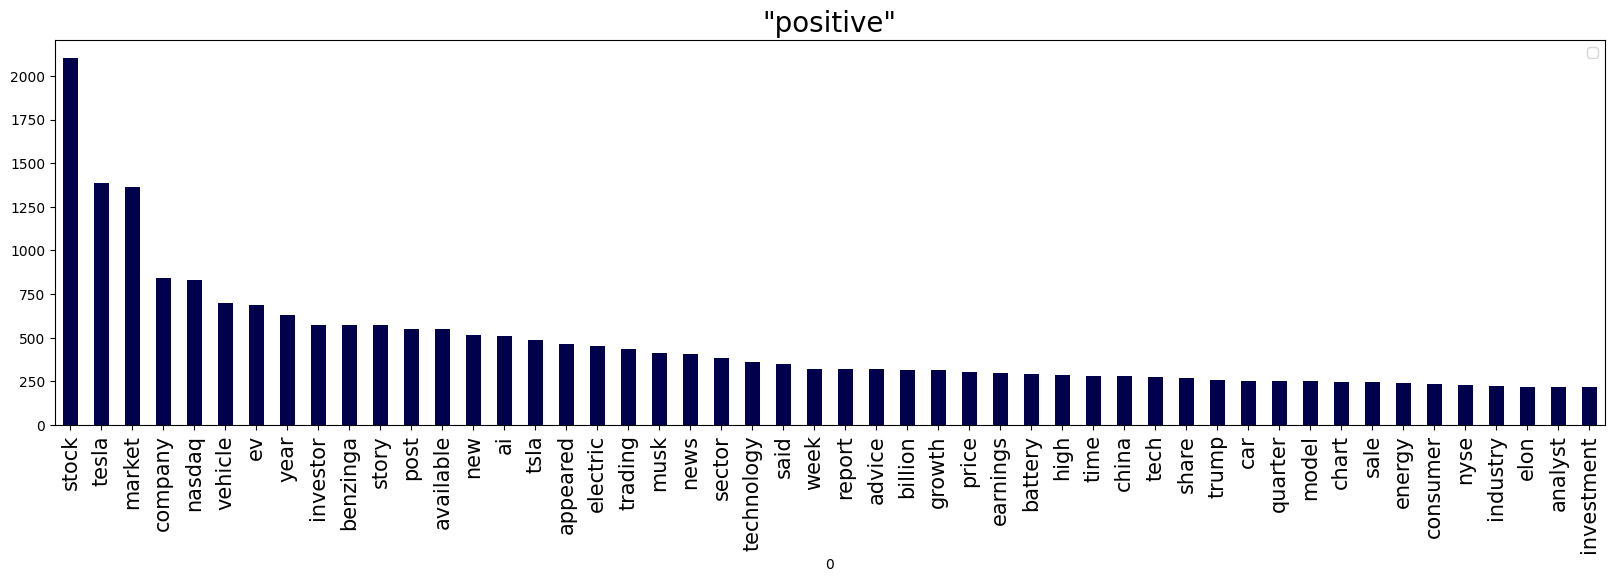

In [14]:
plot_most_common_features(df_en.clean_description, df_en.sentiment)

In [16]:
#We have found that "title" extracts the releavnt keywords (BAG OF WORDS) necessary for sentimental analysis
# Next approach should be applying: BAG OF WORDS Weighting Schemas → TF-IDF Weighting (Use this as the feature for the ML prediction)

In [15]:
# 🔹 Step 1: TF-IDF Vectorization of clean_title
from sklearn.feature_extraction.text import TfidfVectorizer

tfidf_vectorizer = TfidfVectorizer(max_features=5000)
X = tfidf_vectorizer.fit_transform(df_en["clean_title"])


In [16]:
# 🔹 Step 2: Label Encode the sentiment column
from sklearn.preprocessing import LabelEncoder

label_encoder = LabelEncoder()
y = label_encoder.fit_transform(df_en["sentiment"])
print("Encoded classes:", dict(zip(label_encoder.classes_, range(len(label_encoder.classes_)))))


Encoded classes: {'"negative"': 0, '"neutral"': 1, '"positive"': 2}


In [17]:
# 🔹 Step 3: Train/Test Split
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)


In [18]:
# 🔹 Step 4: Train Logistic Regression model
from sklearn.linear_model import LogisticRegression

model = LogisticRegression(max_iter=1000)
model.fit(X_train, y_train)


,penalty,'l2'
,dual,False
,tol,0.0001
,C,1.0
,fit_intercept,True
,intercept_scaling,1
,class_weight,None
,random_state,None
,solver,'lbfgs'
,max_iter,1000
,multi_class,'deprecated'


In [19]:
# 🔹 Step 5: Predict and Evaluate
from sklearn.metrics import classification_report

y_pred = model.predict(X_test)
print("🔍 Classification Report:")
print(classification_report(y_test, y_pred, target_names=label_encoder.classes_))


🔍 Classification Report:
              precision    recall  f1-score   support

  "negative"       0.75      0.46      0.57       463
   "neutral"       0.68      0.90      0.78      1116
  "positive"       0.60      0.28      0.38       323

    accuracy                           0.69      1902
   macro avg       0.68      0.55      0.58      1902
weighted avg       0.69      0.69      0.66      1902



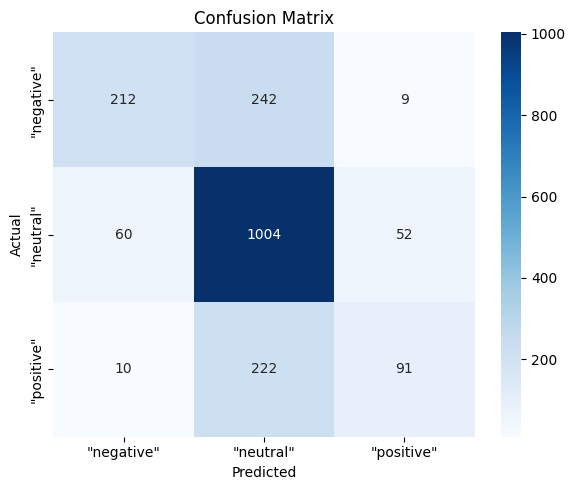

In [20]:
# 🔹 Step 6: Confusion Matrix Plot
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

conf_mat = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(6, 5))
sns.heatmap(conf_mat, annot=True, cmap="Blues", fmt="d",
            xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.tight_layout()
plt.show()


In [21]:
# 🔹 Step 7 (Optional): Print Overall Accuracy
from sklearn.metrics import accuracy_score

acc = accuracy_score(y_test, y_pred)
print(f"🎯 Model Accuracy: {acc:.2%}")


🎯 Model Accuracy: 68.72%


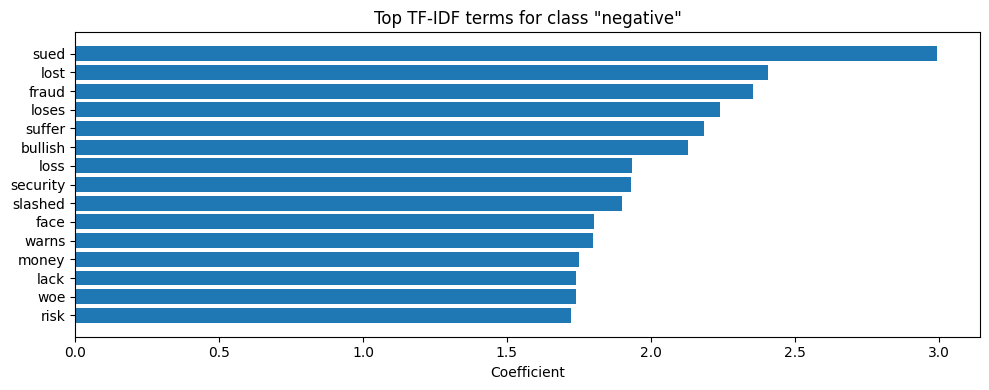

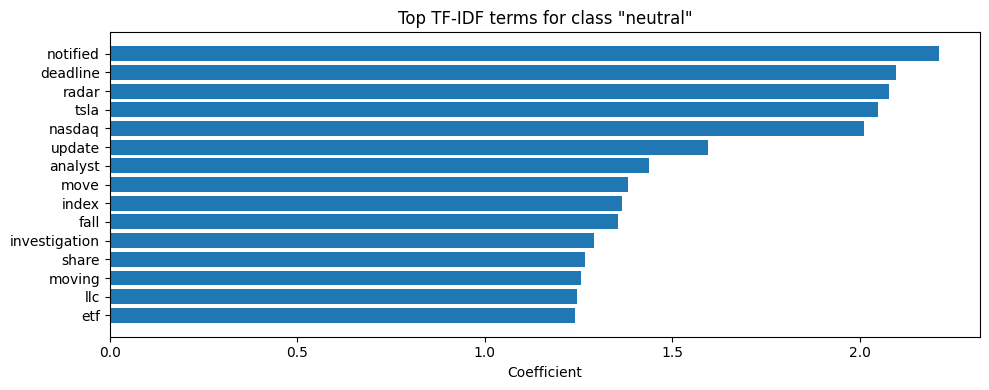

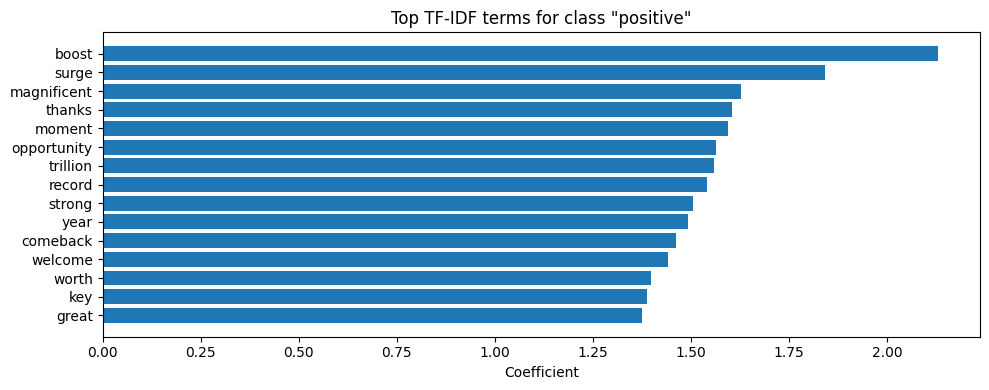

In [22]:
import numpy as np

# Get class labels and coefficients
feature_names = tfidf_vectorizer.get_feature_names_out()
coefs = model.coef_

# Plot top N words per class
def plot_top_terms(class_index, class_label, top_n=15):
    top_features = np.argsort(coefs[class_index])[::-1][:top_n]
    plt.figure(figsize=(10, 4))
    plt.barh(range(top_n), coefs[class_index][top_features][::-1])
    plt.yticks(range(top_n), feature_names[top_features][::-1])
    plt.title(f"Top TF-IDF terms for class {class_label}")
    plt.xlabel("Coefficient")
    plt.tight_layout()
    plt.show()

for i, class_label in enumerate(label_encoder.classes_):
    plot_top_terms(i, class_label)


In [23]:
import pickle

# Save model
with open("logistic_model.pkl", "wb") as f:
    pickle.dump(model, f)

# Save vectorizer
with open("tfidf_vectorizer.pkl", "wb") as f:
    pickle.dump(tfidf_vectorizer, f)

# Save label encoder (optional)
with open("label_encoder.pkl", "wb") as f:
    pickle.dump(label_encoder, f)


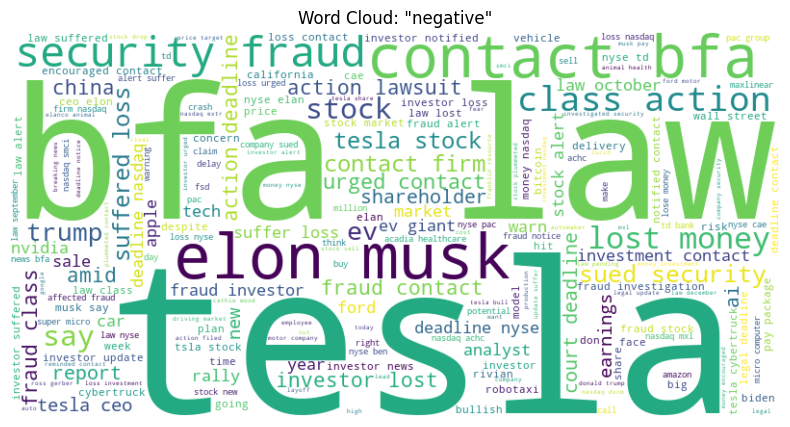

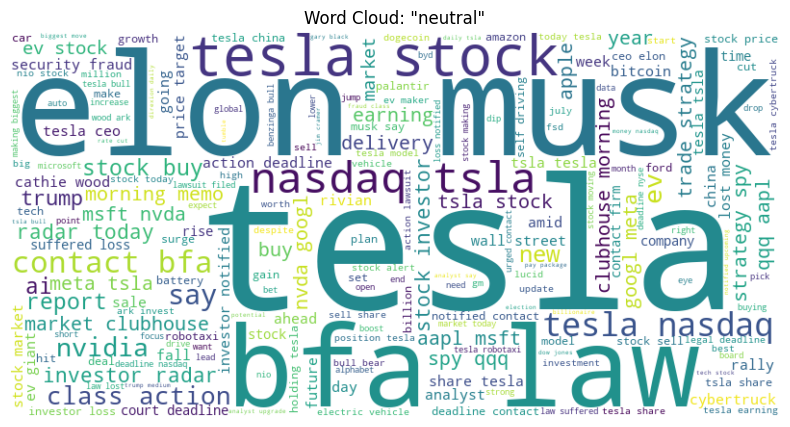

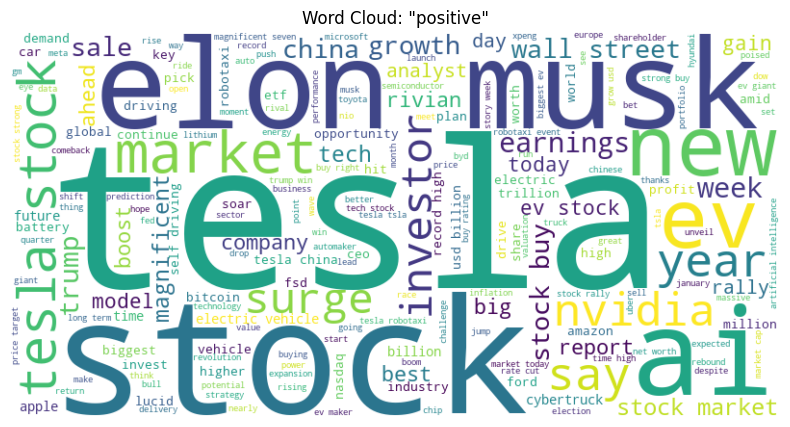

In [24]:
from wordcloud import WordCloud

# Combine titles by sentiment
sentiment_groups = df_en.groupby("sentiment")["clean_title"].apply(lambda x: " ".join(x))

# Generate word clouds
for sentiment, text in sentiment_groups.items():
    wc = WordCloud(width=800, height=400, background_color="white").generate(text)
    plt.figure(figsize=(10, 5))
    plt.imshow(wc, interpolation="bilinear")
    plt.axis("off")
    plt.title(f"Word Cloud: {sentiment}")
    plt.show()


## 🧠 Insights from TF-IDF Term Analysis

By analyzing the top TF-IDF terms per class, we can see which words were most influential in predicting each sentiment:

- 🔴 **Negative**: Words like *"lost"*, *"warn"*, *"fraud"*, and *"disappoint"* indicate fear, decline, or failure — aligning well with negative sentiment.
- ⚪ **Neutral**: Terms such as *"tsla"*, *"nasdaq"*, and *"update"* show neutral reporting or stock movement without emotional tone.
- 🟢 **Positive**: Positive terms like *"boost"*, *"soar"*, *"strong"*, and *"success"* signal financial growth or positive events.

These visualizations validate the model’s decision-making and add transparency to the prediction process.
